# Setup

In [2]:
import os
import pickle
import sys
import warnings

sys.path.append('..')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from effector import ALE
from dalex import Explainer

from utils import preprocess_data, get_zero_nonzero_datasets

In [5]:
# Read in saved models
model_base_path = '/Users/emiliolr/Google Drive/My Drive/LIFE/hunting_analysis/final_models'
models = {'rf' : {'fp': 'rf_hurdle_10.0mins.pkl'},
          'rf-pca' : {'fp' : 'rf-pca_hurdle_10.0mins.pkl'},
          'pymer' : {'fp' : 'pymer_hurdle.pkl'}}

for m in models.values():
    model_fp = os.path.join(model_base_path, m['fp'])
    
    with open(model_fp, 'rb') as f:
        model = pickle.load(f)

    m['model'] = model

# Linear model

In [62]:
# Getting fitted coefficients for the 
linear_hurdle = models['pymer']['model']

nonzero_coefs = linear_hurdle.nonzero_model.model.coefs
nonzero_coefs['variable'] = nonzero_coefs.index
nonzero_coefs = nonzero_coefs.sort_values('Estimate')

zero_coefs = linear_hurdle.zero_model.model.coefs
zero_coefs['variable'] = zero_coefs.index
zero_coefs = zero_coefs.sort_values('Estimate')

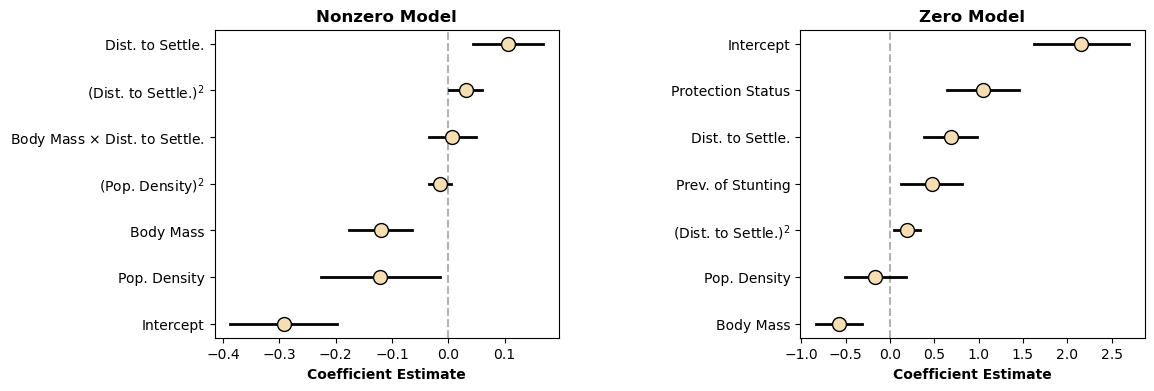

In [63]:
# Plotting model coefficients
#  changing the names for plotting purposes
plot_names = {'Dist_Settlement_KM' : 'Dist. to Settle.',
              'Body_Mass:Dist_Settlement_KM' : 'Body Mass $\\times$ Dist. to Settle.',
              'I(Dist_Settlement_KM^2)' : '(Dist. to Settle.)$^2$',
              'Population_Density' : 'Pop. Density',
              'I(Population_Density^2)' : '(Pop. Density)$^2$', 
              '(Intercept)' : 'Intercept',
              'Body_Mass' : 'Body Mass',
              'Stunting_Pct' : 'Prev. of Stunting',
              'Protected_Area' : 'Protection Status'}

#  plotting
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

for data, model, ax in zip([nonzero_coefs, zero_coefs], ['nonzero', 'zero'], axs):
    ax.scatter(data['Estimate'], data['variable'].replace(plot_names), s = 100, edgecolor = 'black', 
               color = 'wheat', zorder = 100)
    for row in data.iterrows():
        row = row[1]
        name = plot_names[row['variable']]
        ax.plot([row['2.5_ci'], row['97.5_ci']], [name, name], color = 'black', 
                linewidth = 2, zorder = 20)
    
    ax.axvline(0, linestyle = '--', color = 'grey', zorder = 0, alpha = 0.6)

    ax.set_title(f'{model} model'.title(), weight = 'bold')
    ax.set_xlabel('Coefficient Estimate', weight = 'bold')

fig.subplots_adjust(wspace = 0.7)

plt.savefig('/Users/emiliolr/Desktop/linear_hurdle_coefficients.png', bbox_inches = 'tight', dpi = 400)
plt.show()

# Random forest

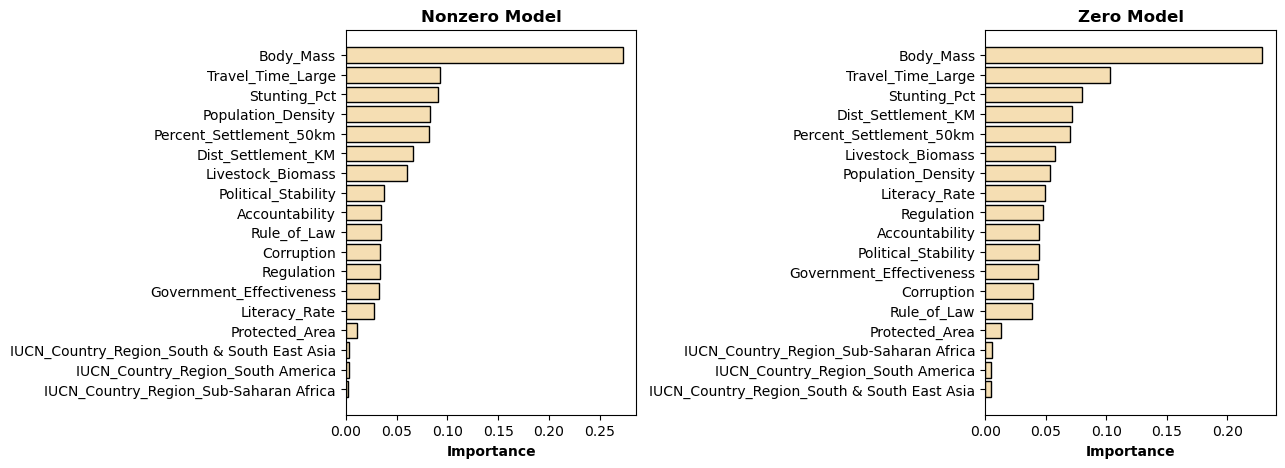

In [69]:
# Plotting random forest feature importances
rf_hurdle = models['rf']['model']
sub_models = {'nonzero' : rf_hurdle.nonzero_model, 'zero' : rf_hurdle.zero_model}

#  names of vars for plotting
plot_names = {'Dist_Settlement_KM' : 'Dist. to Settle.',
              'Population_Density' : 'Pop. Density',
              'Body_Mass' : 'Body Mass',
              'Stunting_Pct' : 'Prev. of Stunting',
              'Protected_Area' : 'Protection Status',
              'Literacy_Rate' : 'Literacy Rate',
              'Travel_Time_Large' : 'Trav. Time to City',
              'Livestock_Biomass' : 'Livestock Biomass',
              'Percent_Settlement_50km' : 'Pct. Area Settled (50 km)'}

fig, axs = plt.subplots(1, 2, figsize = (12, 5), sharey = False)

for i, model_name in enumerate(sub_models.keys()):
    ax = axs[i]
    
    model = sub_models[model_name]
    # model.model.estimator.importance_type = 'gain'

    imp = model.feature_importances_
    feat = model.feature_names_in_
    # feat = [plot_names[f] for f in feat]

    #  sorting by feature importance score
    feat_imp_df = pd.DataFrame({'feature' : feat, 'importance' : imp})
    feat_imp_df = feat_imp_df.sort_values('importance')
    
    ax.barh(feat_imp_df['feature'], feat_imp_df['importance'], color = 'wheat', edgecolor = 'black')
    ax.set_title(f'{model_name} model'.title(), weight = 'bold')
    ax.set_xlabel('Importance', weight = 'bold')

fig.subplots_adjust(wspace = 1.2)

# plt.savefig('/Users/emiliolr/Desktop/feature_importances_rf.png', bbox_inches = 'tight', dpi = 400)
plt.show()

In [20]:
# Joint importance scores, for area of applicability
zero_model_imp = {f : i for f, i in zip(rf_hurdle.zero_model.feature_names_in_, rf_hurdle.zero_model.feature_importances_)}
nonzero_model_imp = {f : i for f, i in zip(rf_hurdle.nonzero_model.feature_names_in_, rf_hurdle.nonzero_model.feature_importances_)}
joint_imp = {}

for f in zero_model_imp.keys():
    mean_imp = (zero_model_imp[f] + nonzero_model_imp[f]) * 0.5
    joint_imp[f] = mean_imp

pd.Series(joint_imp).to_csv('/Users/emiliolr/Desktop/rf_feat_imps.csv')

# Other explainability methods for ML models

In [15]:
# Picking out a model
model_to_use = 'rf-pca'

model = models[model_to_use]['model']
nonzero_model, zero_model = model.nonzero_model, model.zero_model

In [30]:
# Read in the recreated mammal dataset - needed for PDPs!
data_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/benitez_lopez2019_recreated/benitez_lopez2019_recreated_extended.csv'
data = pd.read_csv(data_fp)

#  applying necessary preprocessing to match what was done during final model training
if model_to_use == 'rf-pca':
    pca_cols = ['Corruption', 'Government_Effectiveness', 'Political_Stability', 'Regulation', 
                'Rule_of_Law', 'Accountability']
else:
    pca_cols = None

pp_args = {'include_indicators' : False,
           'include_categorical' : False,
           'polynomial_features' : 0,
           'log_trans_cont' : False,
           'dataset' : 'mammals_recreated',
           'embeddings_to_use' : None,
           'embeddings_args' : None,
           'pca_cols' : pca_cols}

pp_data = preprocess_data(data, standardize = True, **pp_args)
# pp_data = pp_data.drop(columns = ['Response_Ratio'])

#  getting zero/nonzero datasets
X_zero, X_nonzero = get_zero_nonzero_datasets(pp_data, extirp_pos = model.extirp_pos, pred = True, **model.data_args)
y = pp_data['Response_Ratio']

## Partial dependence plots

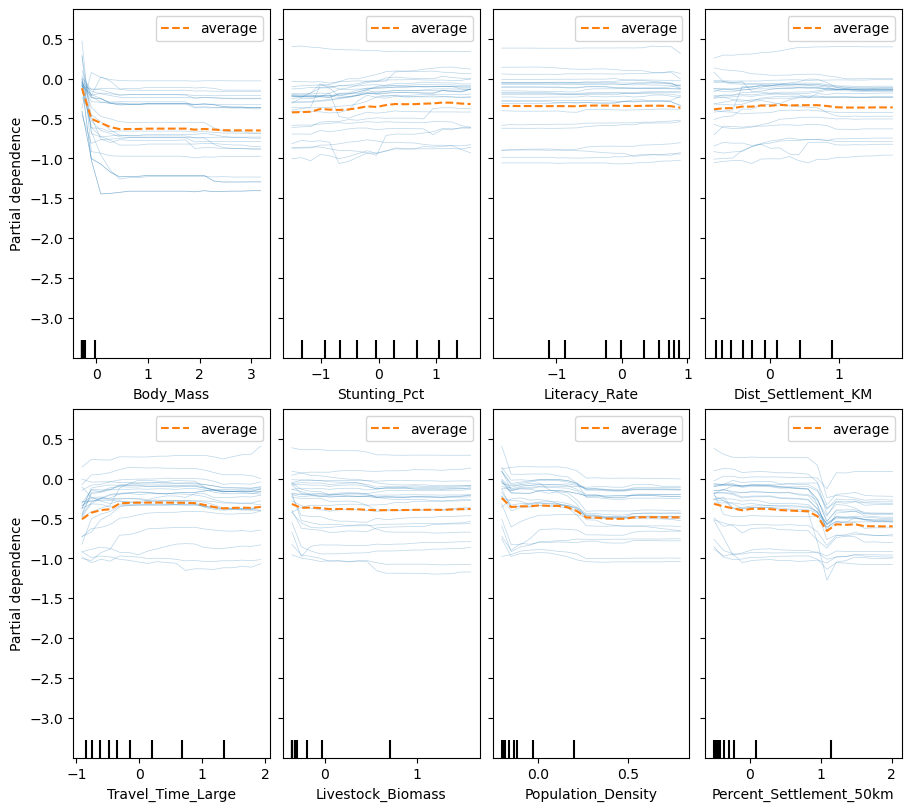

In [102]:
# Code modified from sklearn docs: https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py
#  - FIRST TRYING ON ONLY NONZERO MODEL!
common_params = {
    'subsample' : 25,
    'n_jobs' : 1,
    'grid_resolution' : 20,
    'random_state' : 1693,
}

features_info = {
    'features' : normalized_cols[ : 8],
    'kind' : 'both'
}

_, ax = plt.subplots(ncols = 4, nrows = 2, figsize = (9, 8), constrained_layout = True)
display = PartialDependenceDisplay.from_estimator(nonzero_model, X_nonzero, **features_info,
                                                  ax = ax, **common_params)

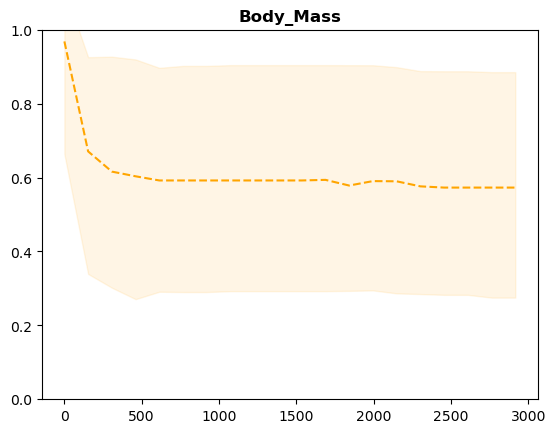

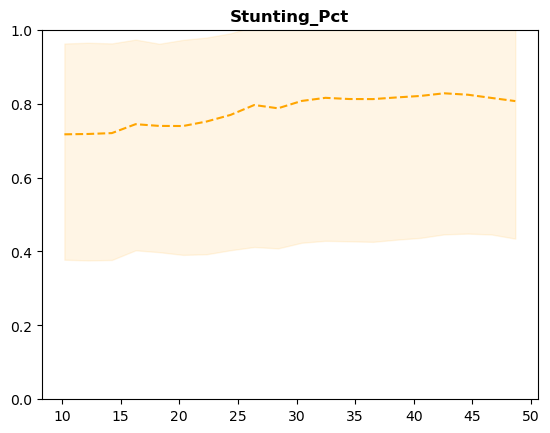

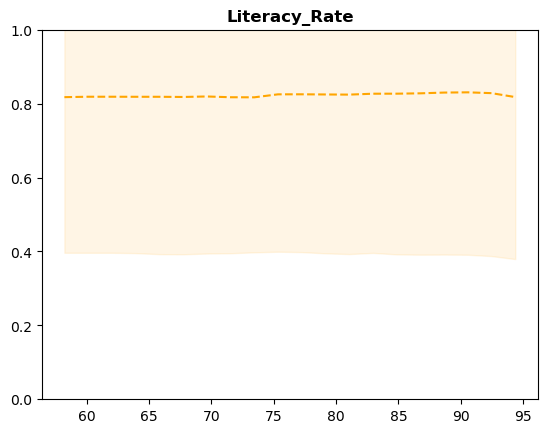

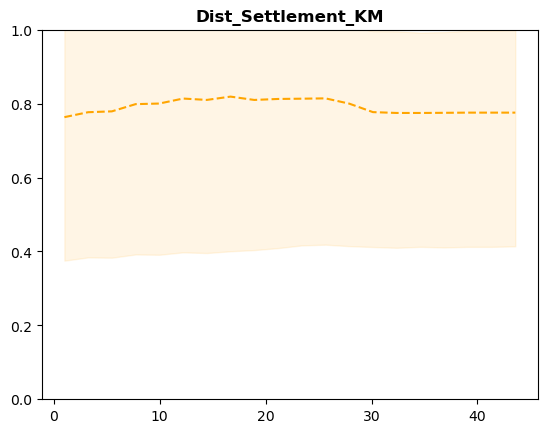

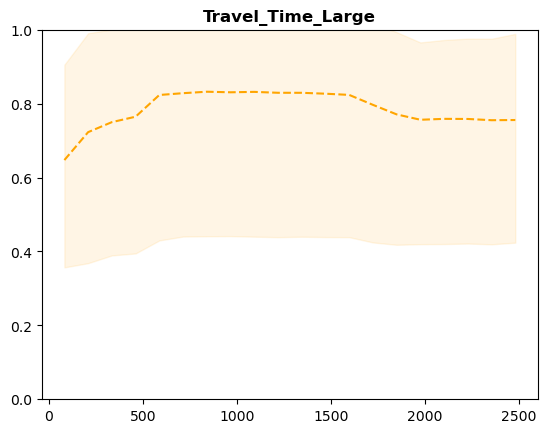

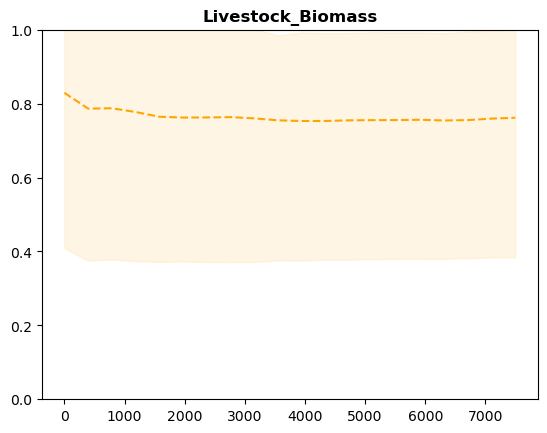

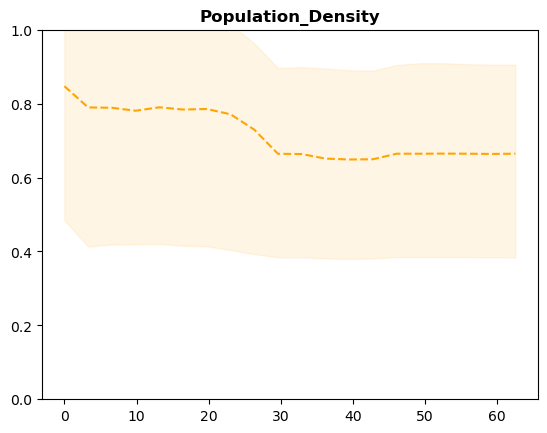

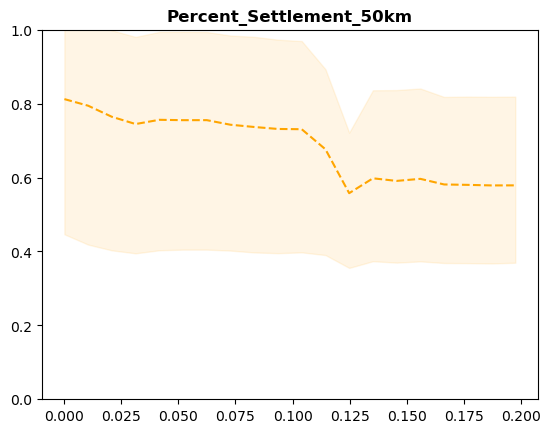

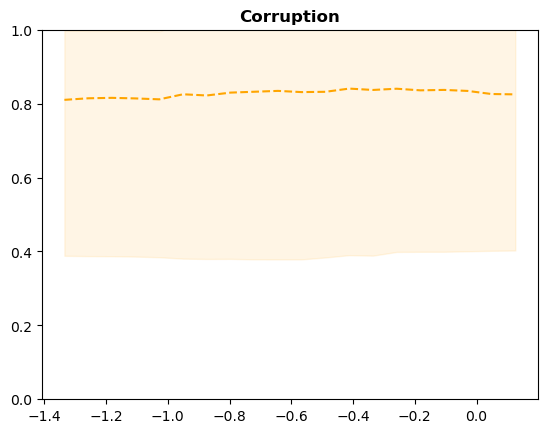

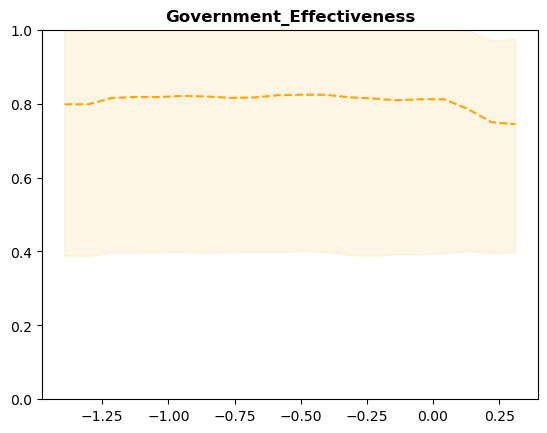

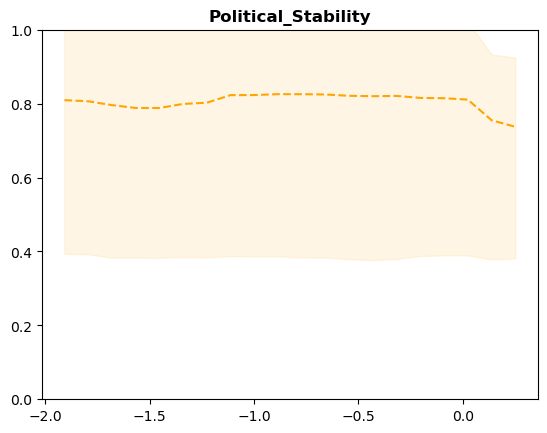

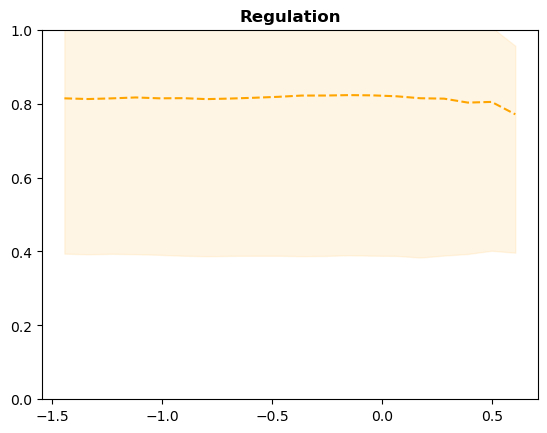

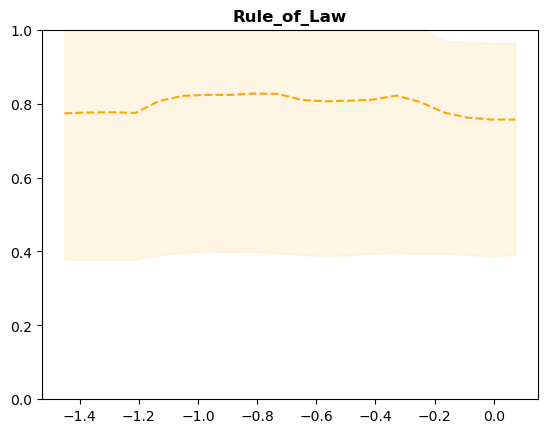

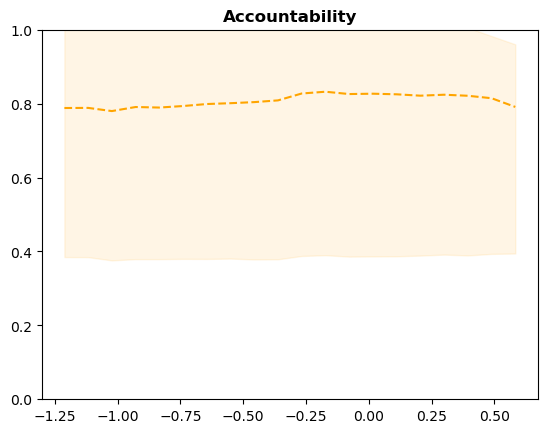

In [101]:
# Trying to dig a little deeper to make these plots more easily interpretable
for f in normalized_cols:
    mean = col_means[f]
    std = col_stds[f]
    
    t = partial_dependence(nonzero_model, X_nonzero, grid_resolution = 20, features = [f], kind = "both")
    
    x = t['grid_values'][0]
    x = (x * std) + mean
    if f == 'Body_Mass':
        x = x / 1000
    
    med = np.median(t['individual'].squeeze(), axis = 0)
    plt.plot(x, np.exp(med), color = 'orange', linestyle = 'dashed')

    plt.ylim(0, 1)
    
    quant_10 = np.quantile(t['individual'].squeeze(), q = 0.1, axis = 0)
    quant_90 = np.quantile(t['individual'].squeeze(), q = 0.90, axis = 0)
    plt.fill_between(x, np.exp(quant_10), np.exp(quant_90), alpha = 0.1, color = 'orange')
    
    plt.title(f, weight = 'bold')
    
    plt.show()

## Accumulated local effects for ML models

Preparation of a new explainer is initiated

  -> data              : 3281 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3281 values
  -> model_class       : flaml.automl.automl.AutoML (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function nonzero_pred_wrapper at 0x3b515ac00> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0388, mean = 0.782, max = 2.15
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.57, mean = 0.425, max = 1.17e+02
  -> model_info        : package flaml

A new explainer has been created!


Calculating ceteris paribus:  80%|███████████████████████████████████████████▏          | 8/10 [00:04<00:01,  1.66it/s]/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.   0.01 0.02 ... 0.98 0.99 1.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating accumulated dependency: 100%|██████████████████████████████████████████████| 10/10 [00:01<00:00,  5.69it/s]


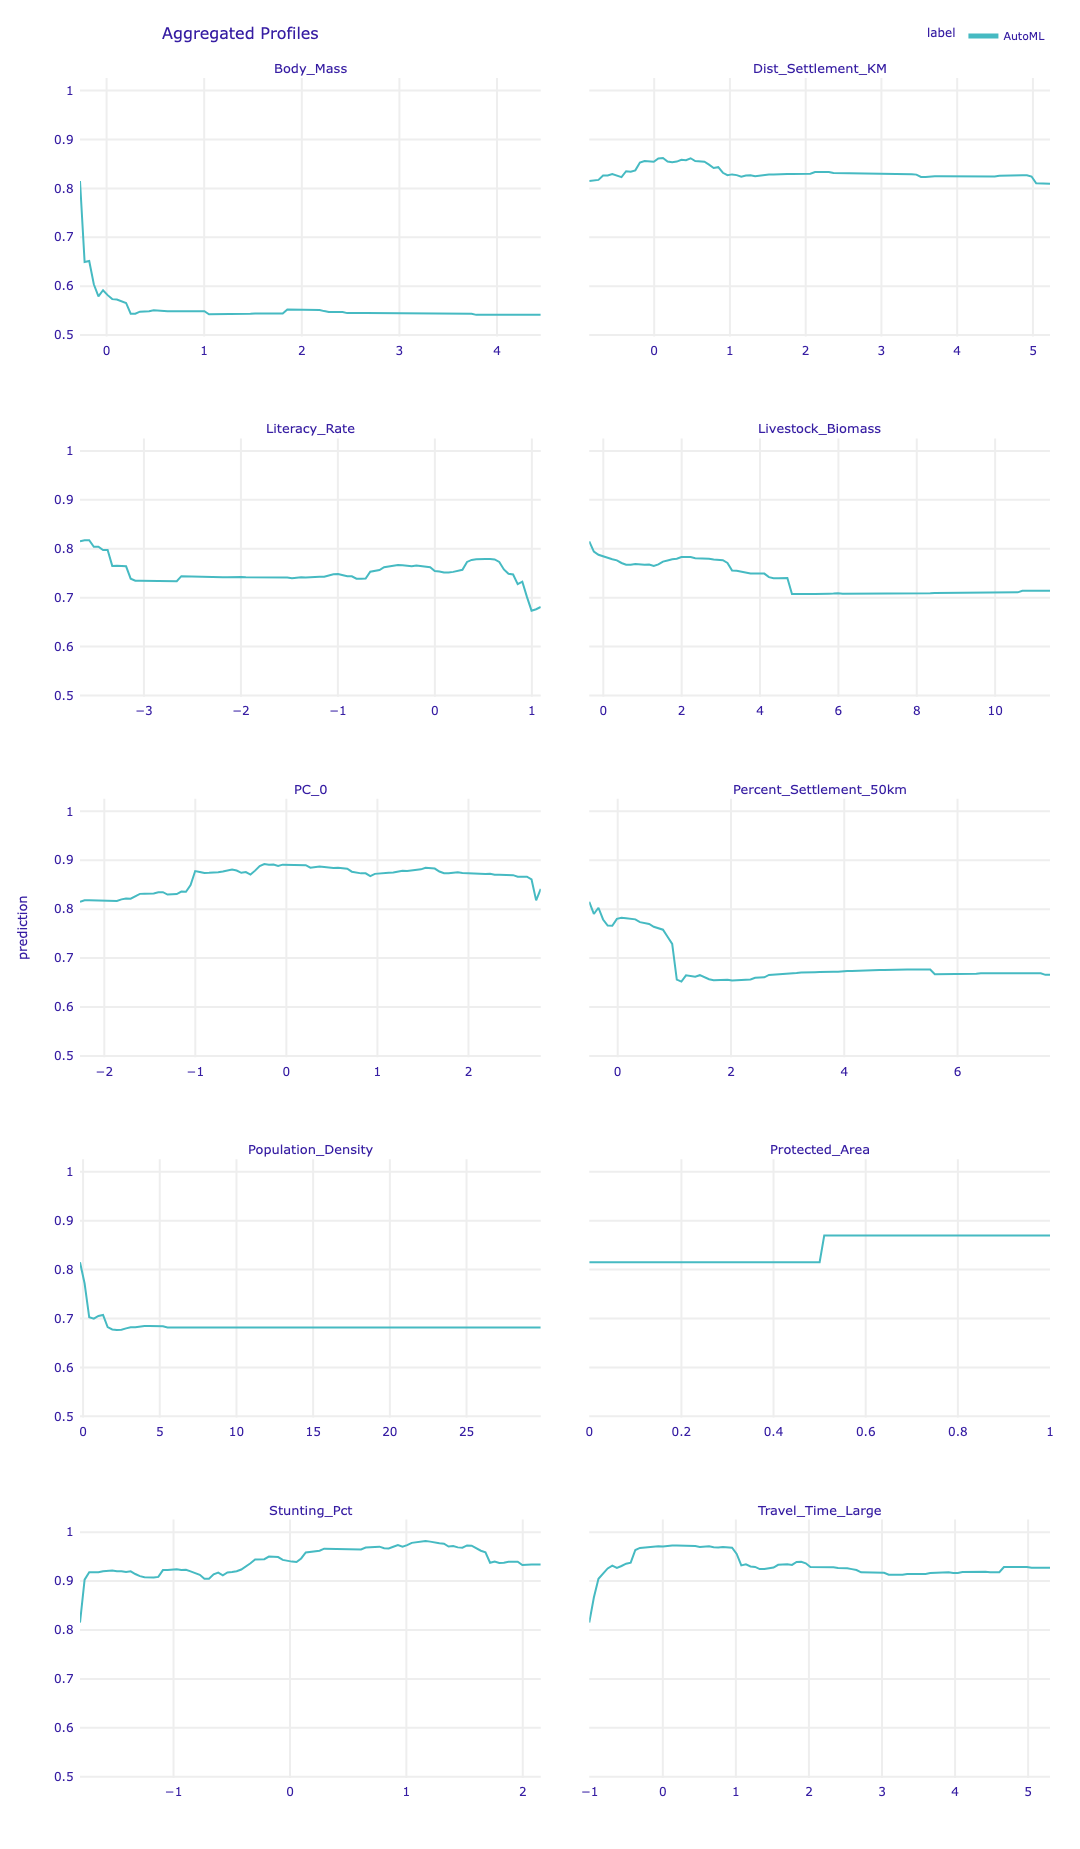

In [68]:
# Looking at the nonzero model
def nonzero_pred_wrapper(model, data):
    return np.exp(model.predict(data))

exp = Explainer(model = nonzero_model, data = X_nonzero, y = y, predict_function = nonzero_pred_wrapper)
ale = exp.model_profile(type = 'accumulated', N = data.shape[0], random_state = 1693)

ale.plot()

Preparation of a new explainer is initiated

  -> data              : 3281 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3281 values
  -> model_class       : flaml.automl.automl.AutoML (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x369abc720> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0396, mean = 0.771, max = 0.996
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.961, mean = 0.436, max = 1.17e+02
  -> model_info        : package flaml

A new explainer has been created!


Calculating ceteris paribus:  80%|███████████████████████████████████████████▏          | 8/10 [00:02<00:00,  3.81it/s]/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.   0.01 0.02 ... 0.98 0.99 1.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating accumulated dependency: 100%|██████████████████████████████████████████████| 10/10 [00:01<00:00,  5.57it/s]


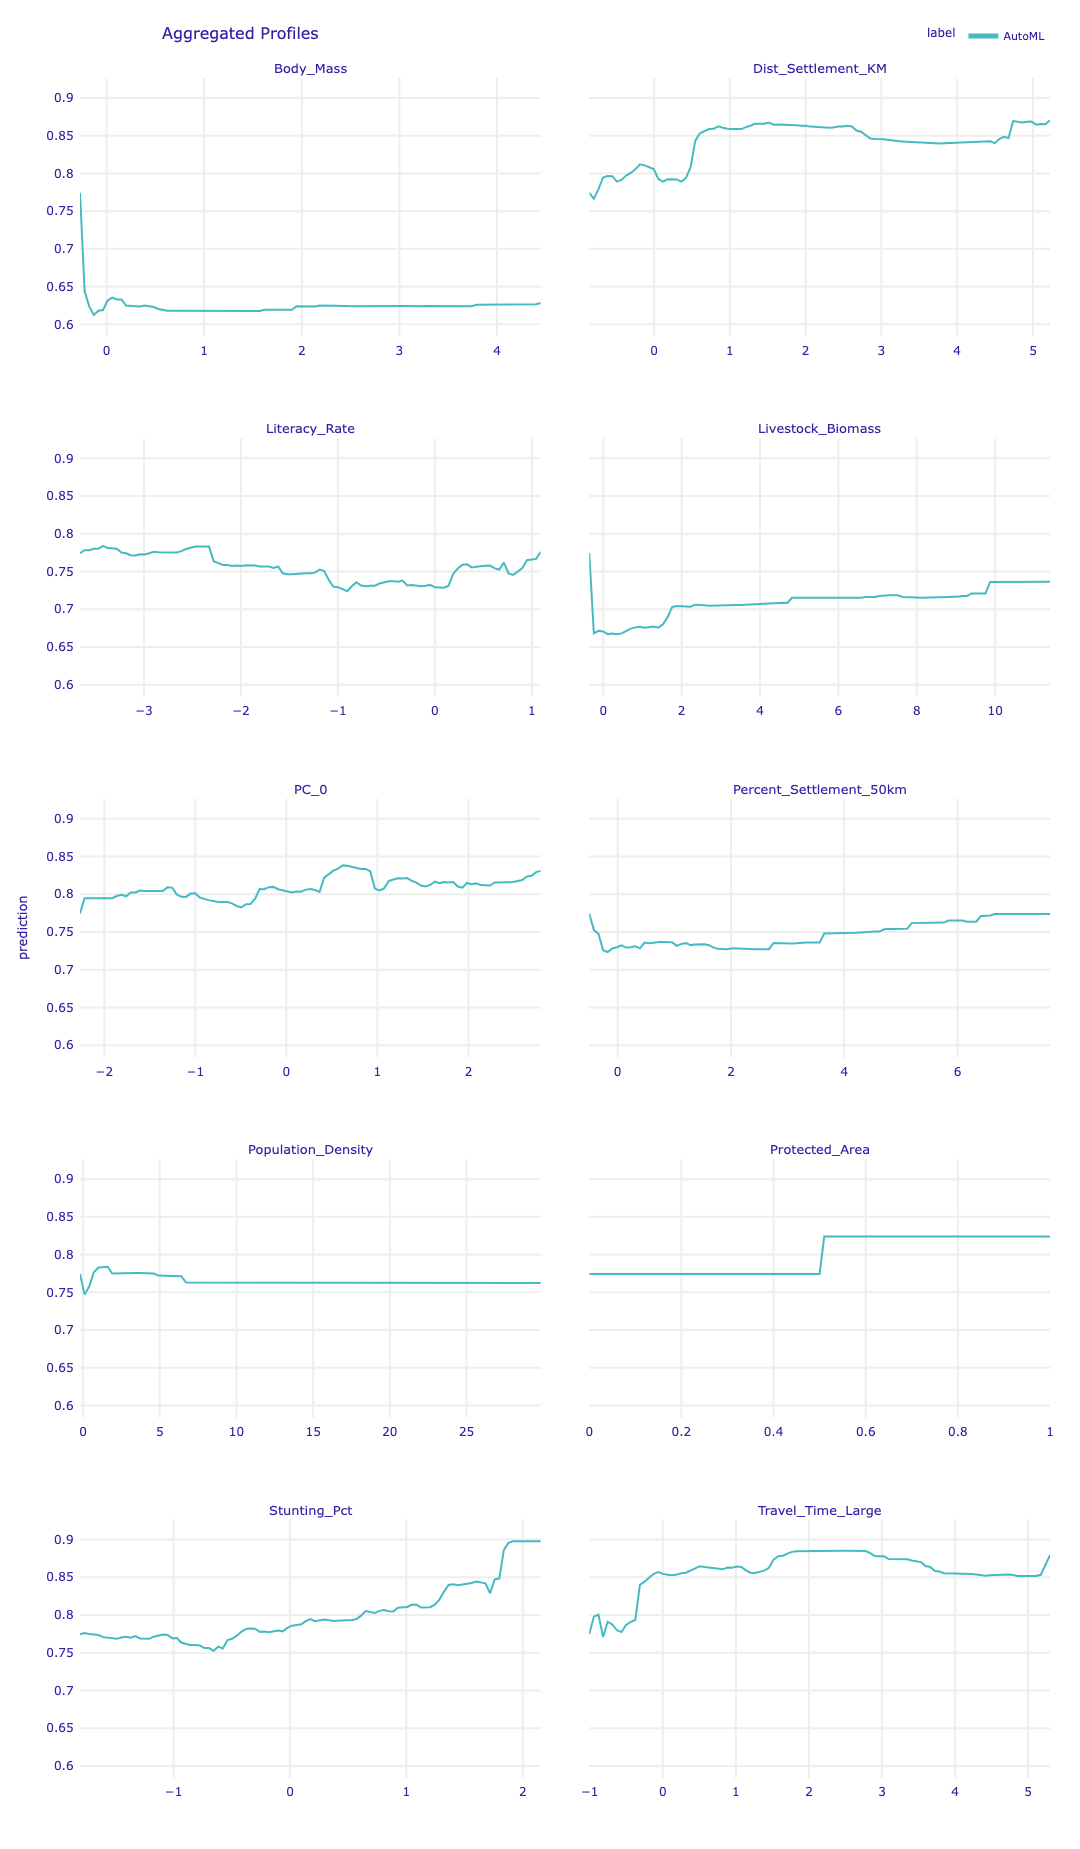

In [76]:
# Looking at the zero model
exp = Explainer(model = zero_model, data = X_zero, y = y)
ale = exp.model_profile(type = 'accumulated', N = data.shape[0], random_state = 1693)

ale.plot()

In [75]:
zero_model.predict_proba(X_zero)

array([[0.04539579, 0.95460421],
       [0.04351326, 0.95648674],
       [0.04539579, 0.95460421],
       ...,
       [0.05305734, 0.94694266],
       [0.05478327, 0.94521673],
       [0.05305734, 0.94694266]])